<a href="https://colab.research.google.com/github/ztjfreedom/colab/blob/master/nnlm_tf_hub_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# How to build a simple text classifier with TF-Hub

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/docs/tutorials/text_classification_with_tf_hub.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/docs/tutorials/text_classification_with_tf_hub.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>


TF-Hub is a platform to share machine learning expertise packaged in reusable resources, notably pre-trained **modules**. This tutorial is organized into two main parts.

** *Introduction:* Training a text classifier with TF-Hub**

We will use a TF-Hub text embedding module to train a simple sentiment classifier with a reasonable baseline accuracy. We will then analyze the predictions to make sure our model is reasonable and propose improvements to increase the accuracy.

** *Advanced:* Transfer learning analysis **

In this section, we will use various TF-Hub modules to compare their effect on the accuracy of the estimator and demonstrate advantages and pitfalls of transfer learning.


## Optional prerequisites

* Basic understanding of Tensorflow [premade estimator framework](https://www.tensorflow.org/get_started/premade_estimators).
* Familiarity with [Pandas](https://pandas.pydata.org/) library.


## Preparing the environment

In [1]:
# Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Getting started

## Data
We will try to solve the [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/) task from Mass et al. The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as **negative** or **positive**.

In [3]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
        fname="aclImdb.tar.gz", 
        origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
        extract=True)
  
    train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                         "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                        "aclImdb", "test"))
  
    return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

84131840/84125825 [==============================] - 12s 0us/step


,sentence,sentiment,polarity
0,Although recognized as the best film treatment...,10,1
1,"This movie is cold, bare truth. Often we think...",9,1
2,I read the back of the box and it talked about...,1,0
3,"Quirky, independent, theatrical, Christian Sla...",3,0
4,I've read every book to date in the left behin...,1,0


## Model
### Input functions

[Estimator framework](https://www.tensorflow.org/get_started/premade_estimators#overview_of_programming_with_estimators) provides [input functions](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn) that wrap Pandas dataframes.

In [0]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

### Feature columns

TF-Hub provides a [feature column](https://github.com/tensorflow/hub/blob/master/docs/api_docs/python/hub/text_embedding_column.md) that applies a module on the given text feature and passes further the outputs of the module. In this tutorial we will be using the [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1). For the purpose of this tutorial, the most important facts are:

* The module takes **a batch of sentences in a 1-D tensor of strings** as input.
* The module is responsible for **preprocessing of sentences** (e.g. removal of punctuation and splitting on spaces).
* The module works with any input (e.g. **nnlm-en-dim128** hashes words not present in vocabulary into ~20.000 buckets).

In [0]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

### Estimator

For classification we can use a [DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) (note further remarks about different modelling of the label function at the end of the tutorial).

In [0]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

### Training

Train the estimator for a reasonable amount of steps.

In [0]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000);

# Prediction

Run predictions for both training and test set.

In [8]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.8004800081253052
Test set accuracy: 0.7934399843215942


## Confusion matrix

We can visually check the confusion matrix to understand the distribution of misclassifications.

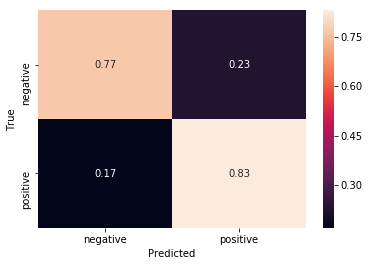

In [9]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(train_df["polarity"], 
                             get_predictions(estimator, predict_train_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

# Further improvements

1. **Regression on sentiment**: we used a classifier to assign each example into a polarity class. But we actually have another categorical feature at our disposal - sentiment. Here classes actually represent a scale and the underlying value (positive/negative) could be well mapped into a continuous range. We could make use of this property by computing a regression ([DNN Regressor](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNRegressor)) instead of a classification ([DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNClassifier)).
2. **Larger module**: for the purposes of this tutorial we used a small module to restrict the memory use. There are modules with larger vocabularies and larger embedding space that could give additional accuracy points.
3. **Parameter tuning**: we can improve the accuracy by tuning the meta-parameters like the learning rate or the number of steps, especially if we use a different module. A validation set is very important if we want to get any reasonable results, because it is very easy to set-up a model that learns to predict the training data without generalizing well to the test set.
4. **More complex model**: we used a module that computes a sentence embedding by embedding each individual word and then combining them with average. One could also use a sequential module (e.g. [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/2) module) to better capture the nature of sentences. Or an ensemble of two or more TF-Hub modules.
5. **Regularization**: to prevent overfitting, we could try to use an optimizer that does some sort of regularization, for example [Proximal Adagrad Optimizer](https://www.tensorflow.org/api_docs/python/tf/train/ProximalAdagradOptimizer).


# Advanced: Transfer learning analysis

Transfer learning makes it possible to **save training resources** and to achieve good model generalization even when **training on a small dataset**. In this part, we will demonstrate this by training with two different TF-Hub modules:

* **[nnlm-en-dim128](https://tfhub.dev/google/nnlm-en-dim128/1)** - pretrained text embedding module,
* **[random-nnlm-en-dim128](https://tfhub.dev/google/random-nnlm-en-dim128/1)** - text embedding module that has same vocabulary and network as **nnlm-en-dim128**, but the weights were just randomly initialized and never trained on real data.

And by training in two modes: 

* training **only the classifier** (i.e. freezing the module), and 
* training the **classifier together with the module**.

Let's run a couple of trainings and evaluations to see how using a various modules can affect the accuracy.

In [0]:
def train_and_evaluate_with_module(hub_module, train_module=False):
    embedded_text_feature_column = hub.text_embedding_column(
        key="sentence", module_spec=hub_module, trainable=train_module)

    estimator = tf.estimator.DNNClassifier(
        hidden_units=[500, 100],
        feature_columns=[embedded_text_feature_column],
        n_classes=2,
        optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

    estimator.train(input_fn=train_input_fn, steps=1000)

    train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

    training_set_accuracy = train_eval_result["accuracy"]
    test_set_accuracy = test_eval_result["accuracy"]

    return {
        "Training accuracy": training_set_accuracy,
        "Test accuracy": test_set_accuracy
    }


results = {}
results["nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1")
results["nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1", True)
results["random-nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1")
results["random-nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1", True)

Let's look at the results.

In [11]:
pd.DataFrame.from_dict(results, orient="index")

,Training accuracy,Test accuracy
nnlm-en-dim128,0.80184,0.79340
nnlm-en-dim128-with-module-training,0.95120,0.87108
random-nnlm-en-dim128,0.72316,0.67600
random-nnlm-en-dim128-with-module-training,0.76820,0.71960


We can already see some patterns, but first we should establish the baseline accuracy of the test set - the lower bound that can be achieved by outputting only the label of the most represented class:

In [12]:
estimator.evaluate(input_fn=predict_test_input_fn)["accuracy_baseline"]

0.5

Assigning the most represented class will give us accuracy of **50%**. There are a couple of things to notice here:

1. Maybe surprisingly, **a model can still be learned on top of fixed, random embeddings**. The reason is that even if every word in the dictionary is mapped to a random vector, the estimator can separate the space purely using its fully connected layers.
2. Allowing training of the module with **random embeddings** increases both training and test accuracy as oposed to training just the classifier.
3. Training of the module with **pre-trained embeddings** also increases both accuracies. Note however the overfitting on the training set. Training a pre-trained module can be dangerous even with regularization in the sense that the embedding weights no longer represent the language model trained on diverse data, instead they converge to the ideal representation of the new dataset.